# COMP1816 Tutorial Week 5 - Numerical Optimisation and feature scaling

This tutorial will be focussing on how we can use numerical optimisation to obtain a minimal cost function as well as how preprocessing to scale our features can aid our ML implementations. 

For this tutorial, read through and try to understand the text and code examples provided (ask your tutor if you have any questions) and then attempt the selection of exercises provided. Attempt these exercises on your own, but do ask your tutor for help if you get stuck.

## 0. Do not forget to import all the Python Libraries being used!

In [ ]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import tensorflow as tf # Tensor flow is a key package for performing automatic differntiation (the gradient descent we use for optimisation)
import sklearn.linear_model, sklearn.datasets # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler # We will be using the imbuilt sclaing functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us

Reminder: To execute a cell, press SHIFT + ENTER or hit the 'play' button on the left of the cell

# 1. Automatic differentiation

As explained in the lectures, our cost function is, as it's a name suggests, simply a mathematical function which relates the parameters of our model (the values in our $\theta$ vector describing our hypothesis) to the error of the models predictions. Obviously we want to minimise this error, which we can do using optimisation.

In order to formulate our optimisation problem I will start with some revision about defining a function and obtaining the function derivative, then showing how tensorflow can help us with this.

## 1.1 Functions and differentiation

A function, at $J$ maps the elements in the set $\theta$ to the set $y$ at it's most basic definition such that $J(\theta) = y = a * \theta^n$ (note, the more usual form you will see in mathematics is $f(x) = y = a * x^n$, but I am using our cost function notation for consistency). The derivative of this function at a given point is the slope of the tangent of the function at that point, which lets us know how that function is changing at that point.

The differentiation function follows a lot of rules depending on the function you are trying to find the derivative of, so I will just give a few examples that will be helpful in this tutorial.


### 1.1.1 Differentiation of a standard function with powers
For a function of the form $J(\theta) = y = a * \theta^n$, the derivative of that function can be defined as 
$\frac{d}{d\theta} J(\theta)= n \times a \theta^{n-1}$

Example:

Let $a=5$, $n=3$ and $\theta=-2$.

Define $J$ by $J(\theta) = a \theta^n = 5 \theta^{3}$.

Then: $J(-2) = 5 (-2)^3=-40$

Find the derivative:

$\frac{d}{d\theta} J(\theta)= n \times a \times \theta^{n-1} = 3 \times 5 \times \theta^2=15\theta^2$

Value at $\theta=-2$: $\frac{d}{d\theta} J(-2)= 15\times -2^2 = 60$

### 1.1.2 Differentiation of a standard function with exponentials
For a function of the form $J(\theta) = y = \exp (\theta^n + a)$ (where $\exp (x)$ is Napier's constant defined by $\mathrm{e}^x$, where $\mathrm{e}=2.71828...$ ), the derivative of that function can be defined as 
$\frac{d}{d\theta} J(\theta)= n\theta^{n-1} \times \exp (\theta^n + a)$

Example:

Let $a=3$, $n=2$ and $\theta=1$.

Define $J$ by $J(\theta) = \exp (\theta^n + a) = \exp (\theta^2 + 3)$.

Then: $J(1) = \exp (1^2 + 3)=54.59815$

Find the derivative:

$\frac{d}{d\theta} J(\theta)= n\theta^{n-1} \times \exp (\theta^n + a) = 2\theta \times \exp (\theta^2 + 3)$

Value at $\theta=1$: $\frac{d}{d\theta} J(1)= 2\times 1  \times \exp (1^2 + 3) = 2 \exp (4) = 109.1963$


Functions and differention are fundamental topics in mathematics that you should have encountered before, so I won't go into any further detail here, but you should be able to find extensive examples of differentiation if you search for 'A level calculus' and 'differentiation rules' either in books or online.

## 1.2 Defining a function to differentiate in Python (Tensorflow)

Define the "variable" (to which which we will calculate the derivative.)
- `tf.Variable(value, dtype=np.float32)`
  - `value` can be a python list, numpy array, or tensorflow Tensor, and will be regarded as the initial value.

Define the "constants" (any variable for which we do not need to calculate the derivative)
- `tf.constant(value, dtype=np.float32)`
  - `value` is the value of the "constant Tensor"
  - Strictly speaking, the "Tensor" defined by this is computationally immutable, so not "constant."

Note: Tensorflow gives us access to many mathematical functions we may have used prior with Numpy.
- Operators are similar to those in Numpy
  - `+, -, *, /`: elementwise addition $+$, subtraction $-$, multiplication $\otimes$, division $\oslash$.
  - `@`: matrix product
- Most mathmatical function can be given by replacing np of a Numpy function by tf.math.
  - `np.sin(x), np.cos(x), np.exp(x)` $\to$ `tf.math.sin(x), tf.math.cos(x), tf.math.exp(x)`.

## 1.3 How to differentiate a function automatically?
The following is the general process we follow for automatically differentiating functions in Python: 

- Define the Variables (e.g., `th` for  $\theta$) and any constants
- Define return value (e.g., `j` for $J(\theta)$ at some value for $\theta$) of the function we want to differentiate in `tf.gradientTape() as tape:` block
- Get the gradient by `tape.gradient()` (e.g., `tape.gradient(j, th)`)
  - The 0th parameter: the return value instance (e.g., `j`).
  - The 1st parameter: the variable instance (e.g., `th`).


### 1.3.1 Automatically differentiate of a standard function with powers
Using the same function as in *1.1.1* - for a function of the form $J(\theta) = y = a * \theta^n$, the derivative of that function can be defined as 
$\frac{d}{d\theta} J(\theta)= n \times a \theta^{n-1}$. 
Let $a=5$, $n=3$ and $\theta=-2$, find the derivative $\frac{d}{d\theta} J(\theta)$:


In [ ]:
th = tf.Variable(-2, dtype=np.float32) # Defining a variable `th`. Here, the initial value is -2. In the following, the derivative will be calculated for `th`.
a = tf.constant(5, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5. 
n = tf.constant(3, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5. 

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block. 
  j = a * (th ** n)
  return j

with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
  j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

# What is the value of our function at `th=-2`?
print('J(-2) =', j.numpy()) # To convert an TensorFlow instance to a NumPy instance, we use the `numpy()` method.

# What is the derivative of our function at `th=-2`?
# tape.gradient(j, th) takes the return value `j` and the variable value `th` to give the derivative at that point.
dj_dth = tape.gradient(j, th) # To calculate the derivative of the function, we use `tape.gradient` method.
print('d/dth J(-2) =', dj_dth.numpy())



J(-2) = -40.0
d/dth J(-2) = 60.0


We should be able to see this matches our example above.

### 1.3.2 Automatically differentiate of a standard function with exponentials
Using the same function as in *1.1.2* - for a function of the form $J(\theta) = y = \exp (\theta^n + a)$, the derivative of that function can be defined as 
$\frac{d}{d\theta} J(\theta)= n\theta^{n-1} \times \exp (\theta^n + a)$. 
Let $a=3$, $n=2$ and $\theta=1$, find the derivative $\frac{d}{d\theta} J(\theta)$:

In [ ]:
th = tf.Variable(1, dtype=np.float32) # Defining a variable `th`. Here, the initial value is 1. In the following, the derivative will be calculated for `th`.
a = tf.constant(3, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 3. 

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block. 
  j = tf.math.exp(th ** 2 + a) # We use tf.math.exp to implement the exponential function.
  return j

with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
  j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

# What is the value of our function at `th=-2`?
print('J(1) =', j.numpy()) # To convert an TensorFlow instance to a NumPy instance, we use the `numpy()` method.

# What is the derivative of our function at `th=-2`?
# tape.gradient(j, th) takes the return value `j` and the variable value `th` to give the derivative at that point.
dj_dth = tape.gradient(j, th) # To calculate the derivative of the function, we use `tape.gradient` method.
print('d/dth J(1) =', dj_dth.numpy())

### 1.3.3 Task 1: Differentiate the sigmoid function
Consider the sigmoid function (which you will be seeing a lot more of later) which takes the form:
$$J(\theta) = \frac{1}{1 + \exp (- a \theta)}$$


Let $a=1$ and $\theta=0$, find the derivative $\frac{d}{d\theta} J(\theta)$:


In [ ]:
##############################################################
# Your code here
##############################################################

th = tf.Variable(0.0, dtype=np.float32)
a = tf.constant(1.0, dtype=np.float32)
def j_func(th):
  j = 1.0 / (1.0 + tf.math.exp(- a * th))
  return j

with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
  j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

# What is the value of our function at `th=-2`?
print('J(0) =', j.numpy()) # To convert an TensorFlow instance to a NumPy instance, we use the `numpy()` method.

# What is the derivative of our function at `th=-2`?
# tape.gradient(j, th) takes the return value `j` and the variable value `th` to give the derivative at that point.
dj_dth = tape.gradient(j, th) # To calculate the derivative of the function, we use `tape.gradient` method.
print('d/dth J(0) =', dj_dth.numpy())

J(0) = 0.5
d/dth J(0) = 0.25


If your code working correctly your code should give you the results: $J(0)=0.5$ and $\frac{d}{d\theta} J(0)=0.25$.

Though if you want to do some maths to double check this and differentiate the sigmoid function by hand be my guest!

## 1.4 Gradient descent

The objective of the gradient descent method is to find the vector $\boldsymbol{\theta}$ which minimises our function $J(\boldsymbol{\theta})$. It does this by calcuating the derivative at a point on the function then updating the position to closer to the minimum based on the gradient and the user defined `learning rate`, hence the implementation required a loop that will calculate the derivative and update $\theta$ at multiple points.

Algorithm
- Inputs: 
  - The initial parameter guess $\boldsymbol{\theta}_\textrm{init}$ (note: ideally we would want to choose values close to the minimum - but if we knew what that was that we wouldn't be needing to use this method! Consequently, you generally start by intiialisng the vector just with zeros or ones)
  - The Learning rate $\alpha$. This must take a value of $\alpha >0$ and is generally less than $1$, but you have to experiment to find the best value for this hyperparameter.
- Initialization: Set your parameter vector $\boldsymbol{\theta} = \boldsymbol{\theta}_\textrm{init}$.
- Repeat the following steps until convergence (when $\boldsymbol{\theta}$ stops changing):
  - Calculate the value of the derviative of the function at the current  $\boldsymbol{\theta}$ values and save this as the variabe $\boldsymbol{g} =\frac{\partial}{\partial \boldsymbol{\theta}} J (\boldsymbol{\theta})$ 
  - Update your estimate of $\boldsymbol{\theta}$ using $\boldsymbol{g}$ and $\alpha$ using: $\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha \boldsymbol{g}$

### 1.4.1 How to apply the gradient descent algorithm in TensorFlow
**Note**: The following explains low-level interfaces of TensorFlow. For machine learning problems, you can also use high-level interfaces of TensorFlow, which will be explained in following weeks for use with Neural Networks, which does a lot of this hard work for you behind the scenes.
- Create `tf.optimizers.SGD` instance.
  - inputs: learning rate $\alpha$.
- For each step in the loop, get the gradient using `tape.gradient` and update the parameters using `optimizers.apply_gradients` from our SGD instance.
  - inputs: the sequence of pairs (tuples of length 2) of the `tf.Variable` instance and the gradient given by `tape.gradient` method for that iteration

Hopefully the commented example below will make things clearer if you don't quite understand.

### 1.4.1 SGD algorithm Example
For our problem we want to find the $\theta$ that minimizes the function $J (\theta)$.

Let:
- $J (\theta) = - \exp(- (\theta - a)^2)$, where $a = 0.5$
- An initial guess $\theta_\textrm{init} = 0.0$
- A learning rate $\alpha = 0.1$

(The solution to this problem should be $J (\theta)$ takes the minimum value $-1.0$ at $\theta = 0.5$)


In [ ]:
# Define the objective function
th = tf.Variable(0, dtype=np.float32) # Defining a variable `th`, this is our `initial guess`
a = tf.constant(0.5, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5. 

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block. 
  j = - tf.math.exp(- (th - a) ** 2)
  return j

learning_rate = 0.1 # Our `alpha` which dictates how much our values can change in a single step.
optimizer = tf.optimizers.SGD(learning_rate) # creating our optimiser object
n_steps = 30 # Numer of steps we want the SGD to run
display_interval = 1 # How often we want to print our outputs (for this case printing every iteration is fine, but you would not want to do this if you weere running thousands of iterations)

for i_step in range(n_steps): # Start loop running from 1-n_steps
  with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
    j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

  dj_dth = tape.gradient(j, th) # Getting the gradient at current theta

  #Note: zip() function combines [dj_dth], [th] into a zipped tuple form the optimiser function needs
  optimizer.apply_gradients(zip([dj_dth], [th])) # Updating `th` using the gradient `dj_dth`.

  # print the current status
  if i_step % display_interval == 0:
    print(f'step {i_step:0=2}: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}, dj/dth = {dj_dth.numpy():+2.4f}')

# print the final results
j = j_func(th)
print(f'Final results: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}')
# Note print(f'....') allows us to format any variables being called

step 00: j = -0.7788, th = +0.0779, dj/dth = -0.7788
step 01: j = -0.8368, th = +0.1485, dj/dth = -0.7064
step 02: j = -0.8838, th = +0.2107, dj/dth = -0.6213
step 03: j = -0.9197, th = +0.2639, dj/dth = -0.5322
step 04: j = -0.9458, th = +0.3085, dj/dth = -0.4466
step 05: j = -0.9640, th = +0.3455, dj/dth = -0.3691
step 06: j = -0.9764, th = +0.3756, dj/dth = -0.3018
step 07: j = -0.9847, th = +0.4001, dj/dth = -0.2449
step 08: j = -0.9901, th = +0.4199, dj/dth = -0.1978
step 09: j = -0.9936, th = +0.4358, dj/dth = -0.1592
step 10: j = -0.9959, th = +0.4486, dj/dth = -0.1278
step 11: j = -0.9974, th = +0.4589, dj/dth = -0.1025
step 12: j = -0.9983, th = +0.4671, dj/dth = -0.0822
step 13: j = -0.9989, th = +0.4736, dj/dth = -0.0658
step 14: j = -0.9993, th = +0.4789, dj/dth = -0.0527
step 15: j = -0.9996, th = +0.4831, dj/dth = -0.0422
step 16: j = -0.9997, th = +0.4865, dj/dth = -0.0337
step 17: j = -0.9998, th = +0.4892, dj/dth = -0.0270
step 18: j = -0.9999, th = +0.4914, dj/dth = -

### 1.4.2 Task 2
Now try applying the SGD yourself to find the $\theta$ that minimizes the function $J (\theta)$.

Let:
- $J (\theta) = \frac{a^2}{\theta} + \theta$, where $a = 0.5$
- An initial guess $\theta_\textrm{init} = 1.0$
- A learning rate $\alpha = 0.1$

(The solution to this problem should be $J (\theta)$ takes the minimum value $1.0$ at $\theta = 0.5$)

To understand the algorithm better, also try altering the following and see how it effects the algorithm:
*   Change the initial guess $\theta_\textrm{init}$ to be closer and further away from the true answer (you might find something interesting if you move too far away...)
*   Try other values of $\alpha$ (remember it must be greater than 0)
*   Try changing the number of steps




In [ ]:
##############################################################
# Your code here
##############################################################

# Define the objective function
th = tf.Variable(1, dtype=np.float32) # Defining a variable `th`, this is our `initial guess`
a = tf.constant(0.5, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5. 

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block. 
  j = ((a ** 2) / th) + th
  return j

learning_rate = 0.1 # Our `alpha` which dictates how much our values can change in a single step.
optimizer = tf.optimizers.SGD(learning_rate) # creating our optimiser object
n_steps = 30 # Numer of steps we want the SGD to run
display_interval = 1 # How often we want to print our outputs (for this case printing every iteration is fine, but you would not want to do this if you weere running thousands of iterations)

for i_step in range(n_steps): # Start loop running from 1-n_steps
  with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
    j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

  dj_dth = tape.gradient(j, th) # Getting the gradient at current theta

  #Note: zip() function combines [dj_dth], [th] into a zipped tuple form the optimiser function needs
  optimizer.apply_gradients(zip([dj_dth], [th])) # Updating `th` using the gradient `dj_dth`.

  # print the current status
  if i_step % display_interval == 0:
    print(f'step {i_step:0=2}: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}, dj/dth = {dj_dth.numpy():+2.4f}')

# print the final results
j = j_func(th)
print(f'Final results: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}')
# Note print(f'....') allows us to format any variables being called

step 00: j = +1.2500, th = +0.9250, dj/dth = +0.7500
step 01: j = +1.1953, th = +0.8542, dj/dth = +0.7078
step 02: j = +1.1469, th = +0.7885, dj/dth = +0.6574
step 03: j = +1.1055, th = +0.7287, dj/dth = +0.5979
step 04: j = +1.0718, th = +0.6758, dj/dth = +0.5292
step 05: j = +1.0457, th = +0.6305, dj/dth = +0.4526
step 06: j = +1.0270, th = +0.5934, dj/dth = +0.3712
step 07: j = +1.0147, th = +0.5644, dj/dth = +0.2900
step 08: j = +1.0073, th = +0.5429, dj/dth = +0.2152
step 09: j = +1.0034, th = +0.5277, dj/dth = +0.1517
step 10: j = +1.0015, th = +0.5175, dj/dth = +0.1023
step 11: j = +1.0006, th = +0.5108, dj/dth = +0.0664
step 12: j = +1.0002, th = +0.5066, dj/dth = +0.0420
step 13: j = +1.0001, th = +0.5040, dj/dth = +0.0260
step 14: j = +1.0000, th = +0.5024, dj/dth = +0.0160
step 15: j = +1.0000, th = +0.5015, dj/dth = +0.0097
step 16: j = +1.0000, th = +0.5009, dj/dth = +0.0059
step 17: j = +1.0000, th = +0.5005, dj/dth = +0.0035
step 18: j = +1.0000, th = +0.5003, dj/dth = +

## 1.5 Using SGD for functions with multiple parameters using vectors/matrices
So far we have only been looking at how to optimise functions with a single parameter, however in reality we are mostly going to be using multivariable functions.
We can account for this by defining vectors and matrices as `tf.Variable` and `tf.constant` instances where we input a list or a NumPy array when creating the variables.


##1.5.1 Two Parameter Example 

For a function $J(\boldsymbol{\theta}) = \sum_{i=0,1}(\theta_{i} - c_{i})^2 =\theta_{0}^2 -2c_{0}\theta_{0} + c_{0}^2 +\theta_{1}^2 -2c_{1}\theta_{1} + c_{1}^2 = (\boldsymbol{\theta} - \boldsymbol{c})^\top (\boldsymbol{\theta} - \boldsymbol{c})$, let our constant vector $\boldsymbol{c} = \begin{bmatrix}2 \\ 3\end{bmatrix}$ and our parameter vector be $\boldsymbol{\theta}  = \begin{bmatrix}\theta_0 \\ \theta_1\end{bmatrix} = \begin{bmatrix}5 \\ 4\end{bmatrix}$


Find:


*   $ J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right)$
*   $\frac{\partial}{\partial \boldsymbol{\theta}} J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right) $


Solution:
- $J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right) =5^2 -2\times 2 \times 5 + 2^2 + 4^2 -2\times 3 \times 4 + 3^2= 10$
- $\frac{\partial}{\partial \boldsymbol{\theta}} J (\boldsymbol{\theta}) = 2 (\boldsymbol{\theta} - \boldsymbol{c})$ (note: this differentiation involves the chain rule, don't worry if you don't fully follow how this worked).
- $\frac{\partial}{\partial \boldsymbol{\theta}} J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right) = 2 \left(\begin{bmatrix}5 \\ 4\end{bmatrix} - \begin{bmatrix}2 \\ 3\end{bmatrix}\right) = \begin{bmatrix}6 \\ 2\end{bmatrix}.$



In [ ]:
# Then solve using Python
th_by_list = [[5],[4]] # Define our list of parameters
c_by_list = [[2],[3]] # Define our list of constants

# Make both into TensorFLow objects
th = tf.Variable(th_by_list, dtype=np.float32)
c = tf.constant(c_by_list, dtype=np.float32)


def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block. 
  j = tf.transpose(th - c) @ (th - c) # (th - c).T does not work in Tensorflow, and remember that `@` is how TF does matrix multiplication.
  return j

with tf.GradientTape() as tape:
  j = j_func(th)


dj_dth = tape.gradient(j, th)
print('j =')
print(j.numpy())
print('dj/dth =')
print(dj_dth.numpy())

Now we have shown how to differentiate this function, we can also now use the SGD method to find the values of $\boldsymbol{\theta}$ that minimise $J(\boldsymbol{\theta})$.

In [ ]:

th_by_list = [[5],[4]] # Define our list of parameters
c_by_list = [[2],[3]] # Define our list of constants

# Make both into TensorFLow objects
th = tf.Variable(th_by_list, dtype=np.float32)
c = tf.constant(c_by_list, dtype=np.float32)

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block. 
  j = tf.transpose(th - c) @ (th - c) # (th - c).T does not work in Tensorflow, and remember that `@` is how TF does matrix multiplication.
  return j

learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 80
display_interval = 10 # The output with vectors is quite long and ugly, so I have increased the display interval
for i_step in range(n_steps): 
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th) # get gradient

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # print the current status
  if i_step % display_interval == 0:
    print(f'step {i_step:0=2}: \nj = \n{j.numpy()}, \nth = \n{th.numpy()}, \ndj/dth = \n{dj_dth.numpy()} \n')

# print the final results
j = j_func(th)
print(f'Final results: j = {j.numpy()}, th = {th.numpy()}')


# 2. Optimisation in machine learning

So far we have been looking at optimisation in the somewhat abstract realm of mathematics, but what we really care about is how we can apply this to our ML models to find the best hypothesis.

These days, most famous machine learning models are generally already implemented in machine learning libraries such as `sklearn`, which makes out lives a lot easier as elements such as the optimisation have already been implemented. However, we sometimes may find a good model in a recent academic paper that has not been implemented in those libraries - in that case, we will have to implement the cost function of the model and optimise it by ourselves.


In the following section we will practice implementing a machine learning model and its optimisation from scratch (Note: this will be a multivariate model, which I have mentioned previously, but will explain in much more detail next week).

## 2.1 Step 1 - Load the data

You should all hopefully be quite familliar with loading data from sklearn now, in particular the California housing dataset.

In [ ]:
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# View the data
display(pd.concat([X_pd, y_pd], axis=1))


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## 2.2 Step 2 - Split the data

Convert our data into arrays and use the sklearn `train_test_split` function to split our data into two sets - one for training and one for evaluation (we will explain the theory behind this in a later week). Note that we are only using a small subset of the data for speed of 'training'.


In [ ]:
# Convert Pandas dataframes to numpy arrays (that our ML models need)
X = X_pd.to_numpy()
y = y_pd.to_numpy() 

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.08, test_size=0.02, shuffle=True, random_state=0)

## 2.3 Step 3 - Data Pre-processing
As described in the lecture, feature scaling has benefits for our ML implementation, one of which is better convergence behaviour for the SGD method.

The two main methods we currently care about are Standaisation and Normalisation (MinMax Scaling), both of which are easy to apply using sklearn.


### Standardization
By calculating the mean and variance for our data columns we can scale each feature so that it has a mean of 0 and a variance of 1.
$$x_s = \frac{x-\mu_x}{\sigma_x}$$
We can standardize the data by the `sklearn.preprocessing.StandardScaler` instance.
- Initialization: `StandardScaler` initializer.
- Calculating the mean and variance (standard deviation) by using `fit` with our object and data.
  - Input: the `np.array` instance of which to calculate the mean and variance.
- Apply the standardization using `transform`.

### Normalisation (MinMax)
By calculating the maximum and minimum values for our data columns we can scale each feature so that it takes a value between 0 and 1.
$$x_s = \frac{x-x_{min}}{x_{max}-x_{min}}$$
We can standardize the data by the `sklearn.preprocessing.MinMaxScaler` instance.
- Initialization: `MinMaxScaler` initializer.
- Calculating the mean and variance (standard deviation) by using `fit` with our object and data.
  - Input: the `np.array` instance of which to calculate the mean and variance.
- Apply the standardization using `transform`.

For our case we will apply standardisation, which is generally a better choice for unbounded data like we are using.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train) # calculate the mean and variance for each feature and store to attributes
print(f'mean = \n{scaler.mean_}, \nvar = \n{scaler.var_}') # print the calculated mean and variance for each attribute
X_train_stded = scaler.transform(X_train) # standardize X_train
print(f'mean = \n{np.mean(X_train_stded, axis=0)}, \nvar = \n{np.var(X_train_stded, axis=0)}') # verify that X_train_stded has mean 0 (mean isn't quite 0 due to numerical error, but is a miniscule value) and variance 1.


mean = 
[ 3.86941211e+00  2.89085403e+01  5.40527659e+00  1.09310084e+00
  1.40576620e+03  3.66859463e+00  3.56305512e+01 -1.19553398e+02], 
var = 
[3.89567163e+00 1.56857171e+02 5.01194690e+00 1.47144384e-01
 9.99838189e+05 9.32007571e+02 4.61078982e+00 3.98138985e+00]
mean = 
[-1.14505619e-15  5.93777669e-17  3.57769538e-15  3.82929438e-16
  5.27204634e-17  4.17636516e-17  9.98797249e-15 -6.73240318e-14], 
var = 
[1. 1. 1. 1. 1. 1. 1. 1.]


### Append a column with 1s. 
As some of you may have noticed last week when implementing Linear Regression with sklearn, the model has (at least) two paramters, the constant 'intercept' and the main coefficients. Sklearn is smart and can ccount for the intercept existing for us, but as we are now fitting the model manually we need to have a extra column of '1s' to account for our intercept ($\theta_0$). We can apply a function to do this as follows:

In [ ]:
# Create 1 appending function
def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

# Use this function to update our training data
X_train_stded_with_one = append_one_to(X_train_stded)

##2.4 Step 4: Optimising the Cost function - Mean Squared Error


### 2.4.1 Define the mean squared error using TensorFlow
As a quick reminder, the Cost function we are using currently is the Mean Squared Error (MSE), we are defining this as follows:
$$J(\boldsymbol{\theta}, \boldsymbol{X}, \boldsymbol{y}) = \frac{1}{m} \sum_{i=0}^{m-1} (\boldsymbol{X}_{i} \boldsymbol{\theta} - \boldsymbol{y}_{i})^2 = \frac{1}{m}(\boldsymbol{X} \boldsymbol{\theta} - \boldsymbol{y})^\top (\boldsymbol{X} \boldsymbol{\theta} - \boldsymbol{y})$$


where $X$ is our matrix of training feature data; $\boldsymbol{y}$ are the observed predicted target values for the target data; $\boldsymbol{\theta}$ is the parameter vector (hypothesis); $m$ is the number of rows in our training data and a subscript of $i$ indicates we are using the $i$th row of training data.

### 2.4.2 Task 3 - Implement the the mean squared error 

For this task I just want you to alter one line to define the MSE correctly using tensorflow to match the definition above. I have an answer hidden in a cell below as we can't contune the tutorial without it, but do attempt to work it out on your own first.

In [ ]:
X = tf.constant(X_train_stded_with_one, dtype=np.float32) # Note, we can put a matrix in as a vector
y = tf.constant(y_train[:, np.newaxis], dtype=np.float32) # We use y as a column vector, that is, m x 1 2D array, not an 1D array. For this reason, we input y_train[:, np.newaxis]
m, n = X_train_stded_with_one.shape # We use the shape function to obtiam our number of rows - `m`
th = tf.Variable(tf.zeros([n, 1], dtype=np.float32)) # Create a vector of zeroes for our initial guess

def j_func(th):
  ####### Your code Here ###################
  j = 0 # Alter this J to calculate the MSE
  j = (1. / m) * (tf.transpose(X @ th - y) @ (X @ th - y))
  ####### end Code ###################
  j = tf.squeeze(j) # the `squeeze` function takes our 1x1 matrix and turns it into a scalar value.
  return j


#### Answer: Don't look without trying it first!

In [ ]:
# Don't look until you've tried it first!

















#j = (1. / m) * (tf.transpose(X @ th - y) @ (X @ th - y))

### 2.4.3 Use the Steepest Gradient method to optimise your cost function

Now we have our data and cost function correctly applied, the application of Steepest gradient is the same as when solving any other function above.

In [ ]:
learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 100
display_interval = 1
for i_step in range(n_steps): 
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th)

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # Print the change of the objective function J
  # not printing out the derivative and th as that will be a lot of output, but feel free to add back if you are interest in their movements.
  if i_step % display_interval == 0:
    print(f'Step {i_step}: j = {j.numpy()}')

j = j_func(th)
print(f'j = {j.numpy()}\nth = \n{th.numpy()}')

Step 0: j = 5.581369876861572
Step 1: j = 3.7893619537353516
Step 2: j = 2.6512207984924316
Step 3: j = 1.9250277280807495
Step 4: j = 1.4598783254623413
Step 5: j = 1.160803198814392
Step 6: j = 0.9676728248596191
Step 7: j = 0.8422714471817017
Step 8: j = 0.7602470517158508
Step 9: j = 0.7060568928718567
Step 10: j = 0.6697632074356079
Step 11: j = 0.6450052857398987
Step 12: j = 0.6277096271514893
Step 13: j = 0.6152610182762146
Step 14: j = 0.6059798002243042
Step 15: j = 0.5987846255302429
Step 16: j = 0.5929818153381348
Step 17: j = 0.5881181955337524
Step 18: j = 0.5839032530784607
Step 19: j = 0.5801476240158081
Step 20: j = 0.5767254829406738
Step 21: j = 0.5735552310943604
Step 22: j = 0.5705822110176086
Step 23: j = 0.5677697658538818
Step 24: j = 0.5650932788848877
Step 25: j = 0.562533974647522
Step 26: j = 0.5600805878639221
Step 27: j = 0.5577225089073181
Step 28: j = 0.5554530024528503
Step 29: j = 0.5532671213150024
Step 30: j = 0.5511600375175476
Step 31: j = 0.549127

### 2.4.4 Make predictions for the target values using our parameters
By considering our problem mathematicall, as matrices, we can make our model predictions by multiplying our new data with the parameter vector we obtained above from our training - $h_{\boldsymbol{\theta}} (\boldsymbol{X_{new}}) = \boldsymbol{\hat{y}} =  \boldsymbol{X_{new}} \boldsymbol{\theta}$


Note: Make sure that any preprocessing done on `X_train` are also done to `X_test` (in this case standardisation and appending a column of 1's). 

In [ ]:
X_test_stded = scaler.transform(X_test) # Standardise new data
X_test_stded_with_one = append_one_to(X_test_stded) # Add a new 

# Make your predictions
y_pred = tf.squeeze(X_test_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

array([ 2.2005138 ,  2.759748  ,  1.9481404 ,  1.1246605 ,  2.8896115 ,
        2.0267205 ,  2.8874698 ,  3.0180454 ,  3.026866  ,  2.2844834 ,
        2.2791395 ,  1.0445206 ,  0.8356216 ,  1.4556385 ,  2.1212845 ,
        2.7725534 ,  3.4174798 ,  1.9949108 ,  1.8786888 ,  2.4553254 ,
        1.5258145 ,  0.9630461 ,  2.854268  ,  2.4214535 ,  1.7302825 ,
        1.6167221 ,  2.0193577 ,  2.1621737 ,  1.7206345 ,  0.9924121 ,
        3.3999183 ,  2.9302325 ,  2.5468786 ,  1.910693  ,  0.6601673 ,
        1.6152725 ,  1.8591053 ,  1.5327145 ,  2.3329792 ,  1.9885747 ,
        1.9455469 ,  1.3954854 ,  1.2034775 ,  2.3640885 ,  2.211987  ,
        0.45574808,  1.7423255 ,  1.8068651 ,  2.3053749 ,  2.5864778 ,
        3.324499  ,  1.2878953 ,  2.6587996 ,  1.4509503 ,  1.4719124 ,
        1.6984377 ,  0.9754816 ,  2.0319312 ,  2.1218524 ,  3.0654101 ,
        1.7075711 ,  1.6990371 ,  1.1997311 ,  2.4067833 ,  1.4344954 ,
        1.5121778 ,  1.2698958 ,  3.3937294 ,  2.3104496 ,  1.24

Now let's try visualising our results and getting our evaluations metrics to see how well we have fit the data.

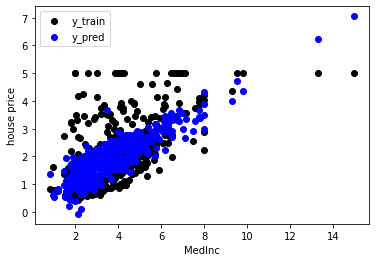

Mean squared error loss: 0.6991
R2 score: 0.4881


In [ ]:
# Plot outputs
X_test_disp = X_test[:,0]
plt.scatter(X_test_disp, y_test,  color='black', label='y_train')
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

### 2.4.5 Task 4

Try implementing the SGD method to fit a model for the diabetes dataset you used last week - you can access it using `sklearn.datasets.load_diabetes()`.
Once you have a model, try and see how various things impact the model accuracy and the optimisation process.
1.   Compare the performance of the model when using normalisation (MinMax scaling) compared to the Standardisation we have been using.
2.   Experiment with the learning rate - what happens if you increase the learning rate to '1' or '0.001'? (you may have to alter the number of steps/display rate to get a good idea of what is happening).
3. Try Running the code without any preprocessing (standardisation or normalisation), how well does the optimisation behave? Compare the final parameter vector with the one you obtained with preprocessing.

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


mean = 
[ 8.34669453e-04  1.80409126e-03 -6.94762087e-04 -6.60729781e-04
 -5.04837638e-04 -8.83187403e-04 -2.17215828e-04  4.24639839e-04
  3.02594295e-05 -1.85912442e-04], 
var = 
[0.00234483 0.00227008 0.00238975 0.00221343 0.00221956 0.00221696
 0.00222709 0.002309   0.00239931 0.00243463]
mean = 
[-3.96283573e-17  8.86920377e-17  5.59829174e-17 -4.85919143e-17
  2.86204802e-17  8.64904623e-18 -2.26447756e-17 -1.10078770e-17
  2.32737971e-17  2.07577109e-17], 
var = 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Step 0: j = 29115.146484375
Step 1: j = 18424.81640625
Step 2: j = 12745.76171875
Step 3: j = 9150.4287109375
Step 4: j = 6852.1123046875
Step 5: j = 5381.2412109375
Step 6: j = 4439.27197265625
Step 7: j = 3835.6103515625
Step 8: j = 3448.499267578125
Step 9: j = 3200.07177734375
Step 10: j = 3040.513671875
Step 11: j = 2937.930419921875
Step 12: j = 2871.904541015625
Step 13: j = 2829.343505859375
Step 14: j = 2801.85693359375
Step 15: j = 2784.068115234375
Step 16: j = 2772.51831054687

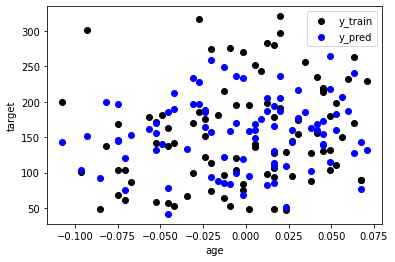

Mean squared error loss: 3461.2503
R2 score: 0.3250


In [ ]:
##############################################################
# Your code here
##############################################################
X_pd, y_pd = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

display(X_pd)

X = X_pd.to_numpy()
y = y_pd.to_numpy() 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)


scaler = StandardScaler()
scaler.fit(X_train) # calculate the mean and variance for each feature and store to attributes
print(f'mean = \n{scaler.mean_}, \nvar = \n{scaler.var_}') # print the calculated mean and variance for each attribute
X_train_stded = scaler.transform(X_train) # standardize X_train
print(f'mean = \n{np.mean(X_train_stded, axis=0)}, \nvar = \n{np.var(X_train_stded, axis=0)}') # verify that X_train_stded has mean 0 (mean isn't quite 0 due to numerical error, but is a miniscule value) and variance 1.

# Create 1 appending function
def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

# Use this function to update our training data
X_train_stded_with_one = append_one_to(X_train_stded)

X = tf.constant(X_train_stded_with_one, dtype=np.float32) # Note, we can put a matrix in as a vector
y = tf.constant(y_train[:, np.newaxis], dtype=np.float32) # We use y as a column vector, that is, m x 1 2D array, not an 1D array. For this reason, we input y_train[:, np.newaxis]
m, n = X_train_stded_with_one.shape # We use the shape function to obtain our number of rows - `m` and columns - 'n'
th = tf.Variable(tf.zeros([n, 1], dtype=np.float32)) # Create a vector of zeroes for our initial guess

def j_func(th):
  j = (1. / m ) * (tf.transpose(X @ th - y) @ (X @ th - y))
  j = tf.squeeze(j) # the `squeeze` function takes our 1x1 matrix and turns it into a scalar value.
  return j

learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 100
display_interval = 1
for i_step in range(n_steps): 
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th)

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # Print the change of the objective function J
  # not printing out the derivative and th as that will be a lot of output, but feel free to add back if you are interest in their movements.
  if i_step % display_interval == 0:
    print(f'Step {i_step}: j = {j.numpy()}')

j = j_func(th)
print(f'j = {j.numpy()}\nth = \n{th.numpy()}')

X_test_stded = scaler.transform(X_test) # Standardise new data
X_test_stded_with_one = append_one_to(X_test_stded) # Add a new 

# Make your predictions
y_pred = tf.squeeze(X_test_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

# Plot outputs
X_test_disp = X_test[:,0] # note we are using unscaled values for our plot. You can use scaled valus, but make sure you don't get confused.
plt.scatter(X_test_disp, y_test,  color='black', label='y_train')
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')
plt.xlabel('age')
plt.ylabel('target')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))